In [1]:
!pip install git+https://github.com/yfw/starter-code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/yfw/starter-code to /tmp/pip-req-build-_ggks55v
  Running command git clone --filter=blob:none --quiet https://github.com/yfw/starter-code /tmp/pip-req-build-_ggks55v
  Resolved https://github.com/yfw/starter-code to commit 9a6269738ba0094d0bd09aea4cc21747b965c6d1
  Preparing metadata (setup.py) ... done
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10300 sha256=4efc77c1b4c5bc8184589cf6cc98cc299567699acd2f9a30a95fac8ec41ef4a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-7cikrsmr/wheels/9f/f8/fb/c2a9093649f3d341959c9d7258b8a128d1afd1b7056c91e5e8
Successfully built Colab-Utils


In [2]:
import coutils
from coutils import fix_random_seed

from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [3]:
# new for project
class Cutout:
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.shape[0]
        w = img.shape[1]
        d = img.shape[2]
        mask = np.ones((h, w, d), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2, 0:d] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask

        return img

from autoaugment import ImageNetPolicy, CIFAR10Policy

# Define mixup function
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [4]:
from torch.utils.data import ConcatDataset
NUM_TRAIN = 49000
add_aug = False

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform_aug = T.Compose([
                #ImageNetPolicy(),
                #CIFAR10Policy(),
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                #Cutout(n_holes=1, length=16),
            ])

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)

if add_aug == True:
  cifar10_train_aug = dset.CIFAR10('./datasets', train=True, download=True, transform=transform_aug)
  cifar10_train = ConcatDataset([cifar10_train, cifar10_train_aug])
  NUM_AUG = 49000
else:
  NUM_AUG = 0

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_AUG)))
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_AUG, 50000+NUM_AUG)))
loader_test = DataLoader(cifar10_test, batch_size=64)

100%|██████████| 170498071/170498071 [00:17<00:00, 9814078.24it/s] 


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


In [36]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 600

print('using device:', device)

using device: cuda:0


In [6]:
def flatten(x, start_dim=1, end_dim=-1):
  return x.flatten(start_dim=start_dim, end_dim=end_dim)

class Flatten(nn.Module):
  def forward(self, x):
    return flatten(x)

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 64, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet56():
    return ResNet(BasicBlock, [9, 9, 9])

def test_ResNet():
  x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
  model = ResNet56()
  scores = model(x)
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]

test_ResNet()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [8]:
class DenseNetBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseNetBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        out = self.conv2(self.relu2(self.bn2(out)))
        out = torch.cat([out, x], 1)
        return out


class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_layers=40, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, growth_rate*2, kernel_size=3, stride=1, padding=1, bias=False)
        self.dense1 = self._make_layer(growth_rate*2, num_layers)
        self.bn1 = nn.BatchNorm2d(growth_rate*(2 + num_layers))
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(growth_rate*(2 + num_layers), num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.dense1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def _make_layer(self, in_channels, num_blocks):
        layers = []
        for i in range(num_blocks):
            layers.append(DenseNetBlock(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

def test_DenseNet():
  x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
  model = DenseNet()
  scores = model(x)
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]

test_DenseNet()

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): DenseNetBlock(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): DenseNetBlock(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(36, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(12, 12, kernel_

In [10]:
# model was already moved to device
def check_accuracy_part34(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

In [11]:
def train_part34(model, optimizer, epochs=1, mixup=False):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Accuracy, also prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    acc = 0
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            # mixup
            if mixup == True:
              x, y_a, y_b, lam = mixup_data(x, y)
              x, y_a, y_b = map(torch.autograd.Variable, (x, y_a, y_b))

            scores = model(x)
            if mixup == True:
              loss = lam * F.cross_entropy(scores, y_a) + (1 - lam) * F.cross_entropy(scores, y_b)
            else:
              loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy_part34(loader_val, model)
                print()
    return acc

In [12]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train_part345(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True, mixup=False):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Accuracy History, also prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  for e in range(epochs):
    
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)

      # mixup
      if mixup == True:
        x, y_a, y_b, lam = mixup_data(x, y)
        x, y_a, y_b = map(torch.autograd.Variable, (x, y_a, y_b))

      scores = model(x)
      if mixup == True:
        loss = lam * F.cross_entropy(scores, y_a) + (1 - lam) * F.cross_entropy(scores, y_b)
      else:
        loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

In [105]:
# moved here to help me better tune the different configurations
# also more updated version

from torch.utils.data import ConcatDataset
NUM_TRAIN = 40000
add_aug = False
increase_data = False

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform_aug = T.Compose([
                #ImageNetPolicy(),
                #CIFAR10Policy(),
                T.ToTensor(),
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # to be consistent with others
                #Cutout(n_holes=1, length=16),
            ])

transform = T.Compose([
                T.ToTensor(),
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # to be consistent with others
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)

cifar10_train_aug = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform_aug)

if add_aug == True and increase_data == True:
  cifar10_train = ConcatDataset([cifar10_train, cifar10_train_aug])
  NUM_AUG = NUM_TRAIN
elif add_aug == True:
  cifar10_train = cifar10_train_aug
  NUM_AUG = 0
else:
  NUM_AUG = 0

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_AUG)))
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [112]:
model = None
optimizer = None

################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
# Replace "pass" statement with your code
fix_random_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

channel_1 = 16
channel_2 = 32
channel_3 = 64

kernel_size_1 = 3
kernel_size_2 = 3
kernel_size_3 = 6

pad_size_1 = 2
pad_size_2 = 1
pad_size_3 = 1

learning_rate = 1e-2
momentum = 0.5
weight_decay = 1e-4

# my own added parameters
pool_kernel_size = 2

# calculate shape between layers
H_after_conv1 = int(H + 2*pad_size_1 - 1*(kernel_size_1-1) - 1 + 1)
W_after_conv1 = int(W + 2*pad_size_1 - 1*(kernel_size_1-1) - 1 + 1)
H_after_pool1 = int((H_after_conv1 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)
W_after_pool1 = int((W_after_conv1 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)

H_after_conv2 = int(H_after_pool1 + 2*pad_size_2 - 1*(kernel_size_2-1) - 1 + 1)
W_after_conv2 = int(W_after_pool1 + 2*pad_size_2 - 1*(kernel_size_2-1) - 1 + 1)
H_after_pool2 = int((H_after_conv2 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)
W_after_pool2 = int((W_after_conv2 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)

H_after_conv3 = int(H_after_pool2 + 2*pad_size_3 - 1*(kernel_size_3-1) - 1 + 1)
W_after_conv3 = int(W_after_pool2 + 2*pad_size_3 - 1*(kernel_size_3-1) - 1 + 1)
H_after_pool3 = int((H_after_conv3 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)
W_after_pool3 = int((W_after_conv3 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)

print(H_after_pool3)
print(W_after_pool3)

model = nn.Sequential(OrderedDict([
  ('conv1', nn.Conv2d(C, channel_1, (kernel_size_1,kernel_size_1), padding=pad_size_1)),
  ('batchnorm1', nn.BatchNorm2d(channel_1)),
  ('relu1', nn.ReLU()),
  #('dropout1', nn.Dropout2d()),
  ('maxpool1', nn.MaxPool2d(pool_kernel_size)),

  ('conv2', nn.Conv2d(channel_1, channel_2, (kernel_size_2,kernel_size_2), padding=pad_size_2)),
  ('batchnorm2', nn.BatchNorm2d(channel_2)),
  ('relu2', nn.ReLU()),
  #('dropout2', nn.Dropout2d()),
  ('maxpool2', nn.MaxPool2d(pool_kernel_size)),

  ('conv3', nn.Conv2d(channel_2, channel_3, (kernel_size_3,kernel_size_3), padding=pad_size_3)),
  ('batchnorm3', nn.BatchNorm2d(channel_3)),
  ('relu3', nn.ReLU()),
  #('dropout3', nn.Dropout2d()),
  ('maxpool3', nn.MaxPool2d(pool_kernel_size)),
  
  # # the ending option 1
  # ('avgpool', nn.AvgPool2d((H_after_pool3, W_after_pool3))),
  # ('flatten', Flatten()),
  # ('fc', nn.Linear(1*1*channel_3, num_classes)),
  
  # the ending option 2
  ('flatten', Flatten()),
  ('fc', nn.Linear(H_after_pool3*W_after_pool3*channel_3, num_classes)),
]))

optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                      weight_decay=weight_decay,
                      momentum=momentum, nesterov=True)
# END OF YOUR CODE

# You should get at least 70% accuracy
# Define a hook to extract the feature map of the second convolutional layer

#model = ResNet56()
#model = DenseNet()

feature_map = None
def get_feature_map(module, input, output):
    global feature_map
    feature_map = output

# Register the hook to the second convolutional layer
hook_handle = model.conv3.register_forward_hook(get_feature_map)

acc = train_part34(model, optimizer, epochs=1, mixup=True)

hook_handle.remove()


2
2
Iteration 0, loss = 2.3726
Checking accuracy on validation set
Got 1042 / 10000 correct (10.42)

Iteration 600, loss = 1.8223
Checking accuracy on validation set
Got 5473 / 10000 correct (54.73)



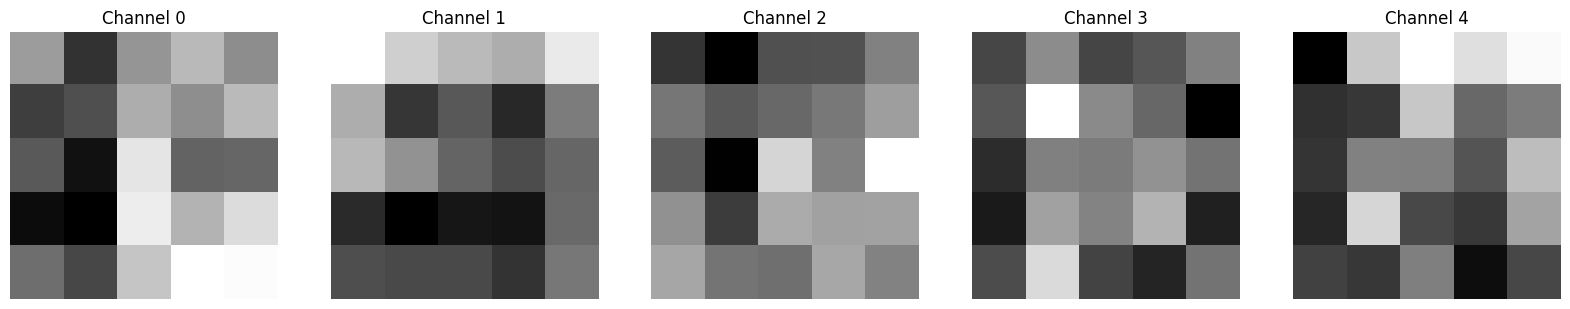

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Assume that feat_map is a tensor of shape (batch_size, num_channels, height, width)
# and that you want to visualize the feature maps for the first example in the batch.

# Extract the feature maps for the first example
new_feature_map = feature_map[0]

# Get the number of channels in the feature map
num_channels = new_feature_map.shape[0]

# Create a figure with subplots for each channel
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))

# Loop over the channels and plot each one in a separate subplot
for i in range(5):
    # Extract the feature map for the current channel
    channel_map = new_feature_map[i, :, :].cpu()
    
    # Normalize the feature map to values between 0 and 1
    channel_map = (channel_map - torch.min(channel_map)) / (torch.max(channel_map) - torch.min(channel_map))
    
    channel_map = channel_map.detach().numpy()
    # Plot the feature map in the current subplot
    axes[i].imshow(channel_map, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title('Channel {}'.format(i))

plt.show()


In [114]:
activations = new_feature_map.reshape(-1)

activations = activations.tolist()

activations = [abs(i) for i in activations]

activations.sort()

# baseline_conv1_activations = activations
# baseline_conv2_activations = activations
# baseline_conv3_activations = activations
# conv1_activations = activations
# conv2_activations = activations
# conv3_activations = activations

print(len(activations))

1600


<BarContainer object of 18496 artists>

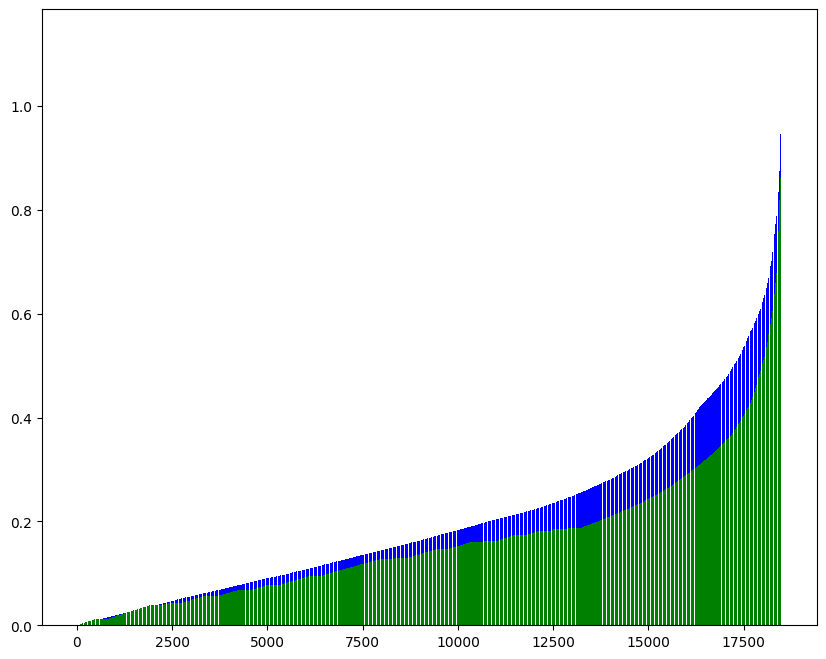

In [115]:
# for conv1

plt.bar(range(len(conv1_activations)), baseline_conv1_activations, color='blue')
plt.bar(range(len(conv1_activations)), conv1_activations, color='green')

<BarContainer object of 9248 artists>

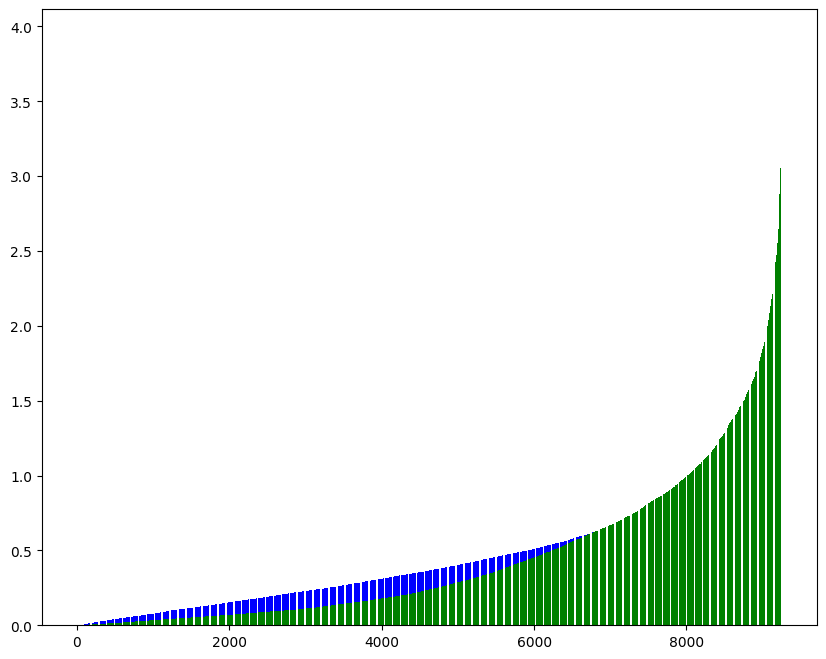

In [116]:
# for conv2 front

plt.bar(range(len(conv2_activations)), baseline_conv2_activations, color='blue')
plt.bar(range(len(conv2_activations)), conv2_activations, color='green')

<BarContainer object of 9248 artists>

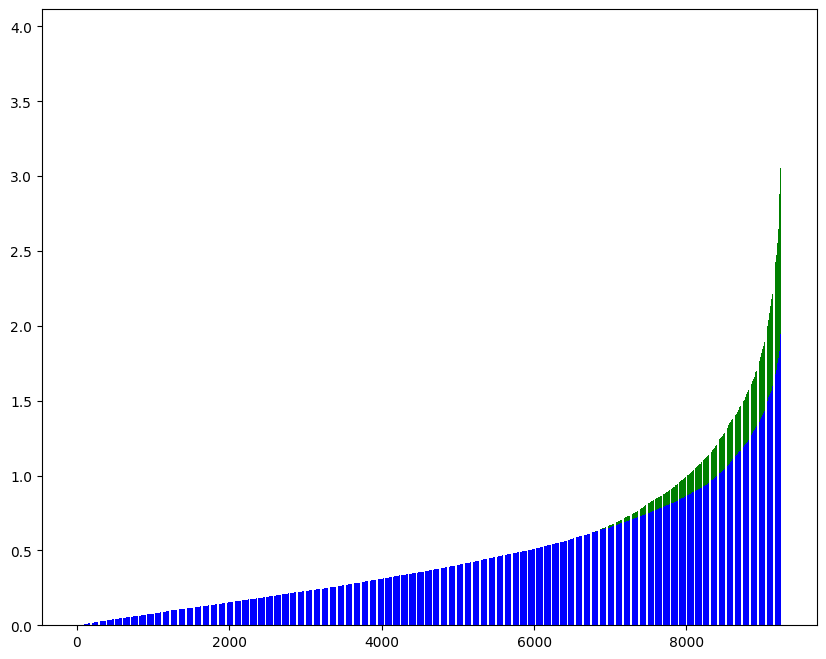

In [119]:
# for conv2 back

plt.bar(range(len(conv2_activations)), conv2_activations, color='green')
plt.bar(range(len(conv2_activations)), baseline_conv2_activations, color='blue')

<BarContainer object of 1600 artists>

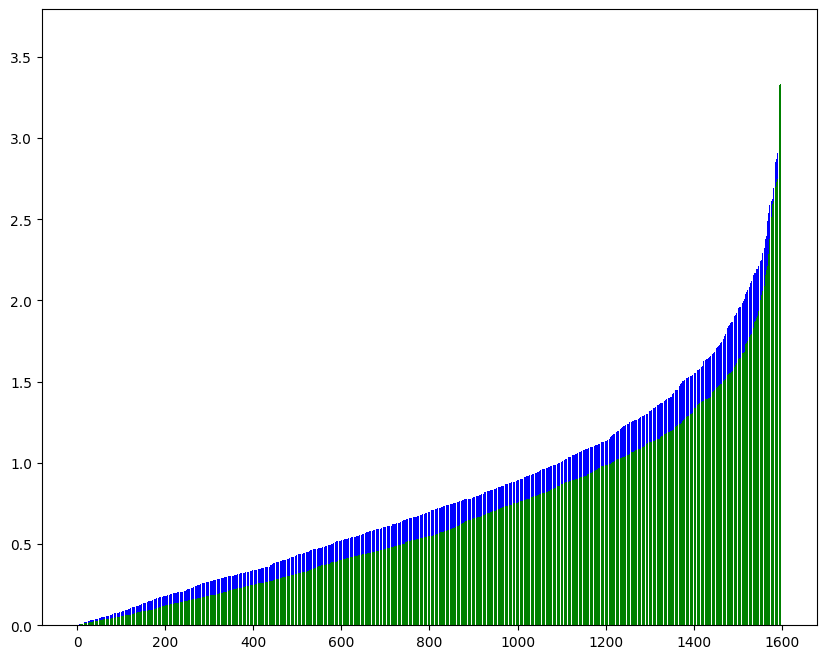

In [118]:
# for conv3

plt.bar(range(len(conv3_activations)), baseline_conv3_activations, color='blue')
plt.bar(range(len(conv3_activations)), conv3_activations, color='green')

In [ ]:
best_model = model
acc_final = check_accuracy_part34(loader_test, best_model)


Checking accuracy on test set
Got 7212 / 10000 correct (72.12)


In [16]:
!pip install ray[tune] bayesian-optimization==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 38.7 MB/s eta 0:00:00
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11683 sha256=8f4a4cc333906b7d39691b8707a65034d4dd9d72e2177ec98b81ee04e51963e8
  Stored in directory: /root/.cache/pip/wheels/14/98/74/190efced439ab92ca551550906290338ba5b64cfc9d0927765
Successfully built bayesian-optimization


In [20]:
from filelock import FileLock

import ray
from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler

from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.bayesopt import BayesOptSearch

In [21]:
from torch.utils.data import ConcatDataset

NUM_TRAIN = 49000
add_aug = False

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform_aug = T.Compose([
                #ImageNetPolicy(),
                #CIFAR10Policy(),
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                #Cutout(n_holes=1, length=16),
            ])

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.

with FileLock(os.path.expanduser("~/.datasets.lock")):
  cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                              transform=transform)

  if add_aug == True:
    cifar10_train_aug = dset.CIFAR10('./datasets', train=True, download=True, transform=transform_aug)
    cifar10_train = ConcatDataset([cifar10_train, cifar10_train_aug])
    NUM_AUG = 49000
  else:
    NUM_AUG = 0

  cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                            transform=transform)

  cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                              transform=transform)


loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_AUG)))
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN+NUM_AUG, 50000+NUM_AUG)))
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [17]:
def train_cifar(config):

  learning_rate = config['lr']
 
  model = None
  optimizer = None
  ################################################################################
  # TODO:                                                                        #         
  # Experiment with any architectures, optimizers, and hyperparameters.          #
  # Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
  #                                                                              #
  # Note that you can use the check_accuracy function to evaluate on either      #
  # the test set or the validation set, by passing either loader_test or         #
  # loader_val as the second argument to check_accuracy. You should not touch    #
  # the test set until you have finished your architecture and  hyperparameter   #
  # tuning, and only run the test set once at the end to report a final value.   #
  ################################################################################
  # Replace "pass" statement with your code
  fix_random_seed(0)

  C, H, W = 3, 32, 32
  num_classes = 10

  channel_1 = 16
  channel_2 = 32
  channel_3 = 64

  kernel_size_1 = 3
  kernel_size_2 = 3
  kernel_size_3 = 6

  pad_size_1 = 2
  pad_size_2 = 1
  pad_size_3 = 1

  #learning_rate = 1e-2
  momentum = 0.5
  weight_decay = 1e-4

  # my own added parameters
  pool_kernel_size = 2

  # calculate shape between layers
  H_after_conv1 = int(H + 2*pad_size_1 - 1*(kernel_size_1-1) - 1 + 1)
  W_after_conv1 = int(W + 2*pad_size_1 - 1*(kernel_size_1-1) - 1 + 1)
  H_after_pool1 = int((H_after_conv1 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)
  W_after_pool1 = int((W_after_conv1 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)

  H_after_conv2 = int(H_after_pool1 + 2*pad_size_2 - 1*(kernel_size_2-1) - 1 + 1)
  W_after_conv2 = int(W_after_pool1 + 2*pad_size_2 - 1*(kernel_size_2-1) - 1 + 1)
  H_after_pool2 = int((H_after_conv2 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)
  W_after_pool2 = int((W_after_conv2 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)

  H_after_conv3 = int(H_after_pool2 + 2*pad_size_3 - 1*(kernel_size_3-1) - 1 + 1)
  W_after_conv3 = int(W_after_pool2 + 2*pad_size_3 - 1*(kernel_size_3-1) - 1 + 1)
  H_after_pool3 = int((H_after_conv3 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)
  W_after_pool3 = int((W_after_conv3 + 2*0 - 1*(pool_kernel_size-1) - 1) / pool_kernel_size + 1)

  print(H_after_pool3)
  print(W_after_pool3)

  model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(C, channel_1, (kernel_size_1,kernel_size_1), padding=pad_size_1)),
    ('batchnorm1', nn.BatchNorm2d(channel_1)),
    ('relu1', nn.ReLU()),
    #('dropout1', nn.Dropout2d()),
    ('maxpool1', nn.MaxPool2d(pool_kernel_size)),

    ('conv2', nn.Conv2d(channel_1, channel_2, (kernel_size_2,kernel_size_2), padding=pad_size_2)),
    ('batchnorm2', nn.BatchNorm2d(channel_2)),
    ('relu2', nn.ReLU()),
    #('dropout2', nn.Dropout2d()),
    ('maxpool2', nn.MaxPool2d(pool_kernel_size)),

    ('conv3', nn.Conv2d(channel_2, channel_3, (kernel_size_3,kernel_size_3), padding=pad_size_3)),
    ('batchnorm3', nn.BatchNorm2d(channel_3)),
    ('relu3', nn.ReLU()),
    #('dropout3', nn.Dropout2d()),
    ('maxpool3', nn.MaxPool2d(pool_kernel_size)),
    
    # # the ending option 1
    # ('avgpool', nn.AvgPool2d((H_after_pool3, W_after_pool3))),
    # ('flatten', Flatten()),
    # ('fc', nn.Linear(1*1*channel_3, num_classes)),
    
    # the ending option 2
    ('flatten', Flatten()),
    ('fc', nn.Linear(H_after_pool3*W_after_pool3*channel_3, num_classes)),
  ]))

  optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                        weight_decay=weight_decay,
                        momentum=momentum, nesterov=True)
  # END OF YOUR CODE

  # You should get at least 70% accuracy
  # Define a hook to extract the feature map of the second convolutional layer

  #model = ResNet56()
  #model = DenseNet()

  acc = train_part34(model, optimizer, epochs=1, mixup=False)


  session.report({"accuracy": acc})




In [23]:
config = {
    "lr": tune.uniform(1e-2, 1e-1)
}

algo = BayesOptSearch(utility_kwargs={"kind": "ucb", "kappa": 2.5, "xi": 0.0})
algo = ConcurrencyLimiter(algo, max_concurrent=4)

tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_cifar),
        resources={"cpu":1, "gpu":1},
    ),
    tune_config=tune.TuneConfig(
        metric="accuracy",
        mode="max",
        search_alg=algo,
    ),
    param_space=config,
)
results = tuner.fit()

(autoscaler +3m18s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'GPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


2023-04-11 20:00:08,008	WARNING tune.py:146 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


(autoscaler +3m53s) Error: No available node types can fulfill resource request {'GPU': 1.0, 'CPU': 1.0}. Add suitable node types to this cluster to resolve this issue.


2023-04-11 20:00:10,050	ERROR tune.py:794 -- Trials did not complete: [train_cifar_cb1056aa]
2023-04-11 20:00:10,052	INFO tune.py:798 -- Total run time: 57.53 seconds (45.42 seconds for the tuning loop).
2023-04-11 20:00:10,053	WARNING tune.py:804 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`
